In [3]:
# # Install the latest TensorFlow version compatible with tf-sentencepiece.
# !pip3 install --quiet tensorflow==1.12.0
# # Install TF-Hub.
# !pip3 install --quiet tensorflow-hub
# !pip3 install --quiet seaborn
# # Install Sentencepiece.
# !pip3 install --quiet tf-sentencepiece

     |████████████████████████████████| 83.1MB 1.2MB/s 
     |████████████████████████████████| 3.1MB 40.8MB/s 
     |████████████████████████████████| 2.4MB 4.9MB/s 


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import seaborn as sns
import tf_sentencepiece

W0618 15:35:43.883618 4359783872 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
# Import our sentence file
en_sent = "./an_enzh/train.tok.tc.en"
zh_sent = "./an_enzh/train.tok.tc.zh"

english_sentences = []
chinese_sentences = []
number_sample = 20

import io
with io.open(en_sent, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    for i, line in enumerate(f):
        english_sentences.append(line[:-1])
#         print(line);
        if i == number_sample - 1: #sample lines
            break;
            
print("Loaded %i lines from en_sent." % len(english_sentences))

with io.open(zh_sent, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    for i, line in enumerate(f):
        chinese_sentences.append(line[:-1])
#         print(line);
        if i == number_sample - 1: #sample lines
            break;
        
print("Loaded %i lines from zh_sent." % len(chinese_sentences))

Loaded 20 lines from en_sent.
Loaded 20 lines from zh_sent.


In [46]:
# filter too long or too short sentences
short_eng_sent = []
short_chi_sent = []
max_char = 150
min_words = 3

print("max_char = %i" % max_char)
print("min_words = %i" % min_words)

for i in range(len(english_sentences)):
    if (len(english_sentences[i]) <= max_char and 
        len(chinese_sentences[i]) <= max_char and
        len(english_sentences[i].split()) >= min_words and 
        len(chinese_sentences[i].split()) >= min_words):
        short_eng_sent.append(english_sentences[i])
        short_chi_sent.append(chinese_sentences[i])

print("Loaded %i lines from short_eng_sent." % len(short_eng_sent))
print("Loaded %i lines from short_chi_sent." % len(short_chi_sent))

max_char = 150
min_words = 3
Loaded 10 lines from short_eng_sent.
Loaded 10 lines from short_chi_sent.


In [59]:
# filter duplicate sentences
eng_chi_dict = {}
for i in range(len(short_eng_sent)):
    eng_chi_dict[short_eng_sent[i]]=short_chi_sent[i]

chi_eng_dict = {v: k for k, v in eng_chi_dict.items()}

uni_short_eng = list(chi_eng_dict.values())
uni_short_chi = list(chi_eng_dict.keys())

print("Loaded %i lines from uni_short_eng." % len(uni_short_eng))
print("Loaded %i lines from uni_short_chi." % len(uni_short_chi))

Loaded 8 lines from uni_short_eng.
Loaded 8 lines from uni_short_chi.


In [56]:
# print(" ".join(random.sample(uni_short_eng[1].split(), random.randint(1,len(uni_short_eng[1].split())))))

In [57]:
# print(" ".join(uni_short_eng[1].split()[0:random.randint(1,len(uni_short_eng[1].split()))]))

In [60]:
# mock up bad translations
import random
mix_short_eng = uni_short_eng
mix_short_chi = uni_short_chi

for i in range(len(uni_short_eng)):
    # random crop from the left
    mix_short_eng.append(" ".join(uni_short_eng[i].split()[0:random.randint(1,len(uni_short_eng[i].split()))]))
    mix_short_chi.append(" ".join(uni_short_chi[i].split()[0:random.randint(1,len(uni_short_chi[i].split()))]))
#     # random crop & disorder
#     mix_short_eng.append(" ".join(random.sample(uni_short_eng[i].split(), random.randint(1,len(uni_short_eng[i].split())))))
#     mix_short_chi.append(" ".join(random.sample(uni_short_chi[i].split(), random.randint(1,len(uni_short_chi[i].split())))))

print("Loaded %i lines from mix_short_eng." % len(mix_short_eng))
print("Loaded %i lines from mix_short_chi." % len(mix_short_chi))

Loaded 16 lines from mix_short_eng.
Loaded 16 lines from mix_short_chi.


In [28]:
# The 8-language multilingual module. There are also en-es, en-de, and en-fr bilingual modules.
module_url = "https://tfhub.dev/google/universal-sentence-encoder-xling-many/1"

# Set up graph.
g = tf.Graph()
with g.as_default():
  text_input = tf.placeholder(dtype=tf.string, shape=[None])
  xling_8_embed = hub.Module(module_url)
  embedded_text = xling_8_embed(text_input)
  init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()

# Initialize session.
session = tf.Session(graph=g)
session.run(init_op)

# Compute embeddings.
en_result = session.run(embedded_text, feed_dict={text_input: mix_short_eng})
zh_result = session.run(embedded_text, feed_dict={text_input: mix_short_chi})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0618 16:12:55.166797 4359783872 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [45]:
# output first line: number of vectors and embedding dimension
# Replace the ‘blank’ with underscore

num_vector = len(mix_short_eng)
emb_dim = len(en_result[0]) 

print("num_vector = %i" % num_vector)
print("emb_dim = %i" % emb_dim)

# output embeddings
with open('./data/src_emb_en.txt', 'w') as f:
    for i in range(len(mix_short_eng)+1):
        if i == 0:
            f.write(str(num_vector)+' '+str(emb_dim)+'\n')
        else:
            f.write(str(mix_short_eng[i-1]).replace(' ','_')+' '+str(en_result[i-1].tolist())[1:-1].replace(',',' ')+'\n')

print("src_emb_en.txt done")

with open('./data/tgt_emb_zh.txt', 'w') as f:
    for i in range(len(mix_short_chi)+1):
        if i == 0:
            f.write(str(num_vector)+' '+str(emb_dim)+'\n')
        else:
            f.write(str(mix_short_chi[i-1]).replace(' ','_')+' '+str(zh_result[i-1].tolist())[1:-1].replace(',',' ')+'\n')

print("tgt_emb_zh.txt done")

num_vector = 20
emb_dim = 512
src_emb_en.txt done
tgt_emb_zh.txt done


In [215]:
from src.utils import bool_flag, initialize_exp
from src.models import build_model
from src.trainer import Trainer
from src.evaluation import Evaluator
from src.logger import create_logger
from src.dictionary import Dictionary

from logging import getLogger
logger = getLogger()

In [240]:
_emb_dim_file = 512 # default=300, help="Embedding dimension"
max_vocab = 200000 # default=200000, help="Maximum vocabulary size (-1 to disable)"
full_vocab=False
"""
Reload pretrained embeddings.
- `full_vocab == False` means that we load the `params.max_vocab` most frequent words.
  It is used at the beginning of the experiment.
  In that setting, if two words with a different casing occur, we lowercase both, and
  only consider the most frequent one. For instance, if "London" and "london" are in
  the embeddings file, we only consider the most frequent one, (in that case, probably
  London). This is done to deal with the lowercased dictionaries.
- `full_vocab == True` means that we load the entire embedding text file,
  before we export the embeddings at the end of the experiment.
"""

word2id = {}
vectors = []
   
# def read_txt_embeddings(params, source, full_vocab):
# with io.open(wiki_en_sent, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
with io.open(src_emb_en, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    for i, line in enumerate(f):
        if i == 0:
            split = line.split()
            assert len(split) == 2 # first line contains two numbers: ??? and embedding dimension
            assert _emb_dim_file == int(split[1]) # second number is num_dim
        else:
            word, vect = line.rstrip().split(' ', 1) #get the word & vectors
#             print('else-word:'+word)
#             print('else-vect:'+vect[0])
#             print('type(vect):'+str(type(vect)))
            if not full_vocab: # will lower case and read the most frequent words
                word = word.lower()
#                 print('if not full_vocab:'+word)
            vect = np.fromstring(vect, sep=' ')
#             print('np.fromstring:'+str(vect.tolist()))
#             print('np.linalg.norm(vect)='+str(np.linalg.norm(vect).tolist()))
            if np.linalg.norm(vect) == 0:  # avoid to have null embeddings
                vect[0] = 0.01 # IndexError: index 0 is out of bounds for axis 0 with size 0
            if word in word2id:
                if full_vocab:
                    pass
#                     logger.warning("Word '%s' found twice in %s embedding file"
#                                    % (word, 'source' if source else 'target'))
            else:
                if not vect.shape == (_emb_dim_file,):
                    pass
#                     logger.warning("Invalid dimension (%i) for %s word '%s' in line %i."
#                                    % (vect.shape[0], 'source' if source else 'target', word, i))
                    continue
                assert vect.shape == (_emb_dim_file,), i
                word2id[word] = len(word2id)
#                 print(vect[None]+'\n')
                vectors.append(vect[None])
        if max_vocab > 0 and len(word2id) >= max_vocab and not full_vocab:
            break

assert len(word2id) == len(vectors)
logger.info("Loaded %i pre-trained word embeddings." % len(vectors))

# compute new vocabulary / embeddings
id2word = {v: k for k, v in word2id.items()}
# dico = Dictionary(id2word, word2id, lang)

else-word:@0
else-vect:-
type(vect):<class 'str'>
if not full_vocab:@0
np.fromstring:[-0.03716230019927025, 0.10215236246585846, -0.04183743894100189, 0.05814386159181595, 0.009404619224369526, -0.015961594879627228, -0.048760831356048584, -0.0036918327677994967, -0.01528859417885542, -0.027137957513332367, -0.03131179139018059, -0.011146180331707, -0.036993809044361115, 0.04673592001199722, -0.02558889053761959, 0.052338309586048126, 0.003236575284972787, -0.04067488759756088, -0.08238464593887329, 0.03794777765870094, 0.01301850751042366, -0.04326879233121872, -0.056980617344379425, 0.059389278292655945, 0.008558892644941807, -0.048324547708034515, -0.04801512509584427, -0.0186392180621624, 0.035087186843156815, -0.024444976821541786, 0.055706560611724854, 0.05608029663562775, -0.015188392251729965, -0.011954985558986664, -0.05059422180056572, 0.07743316888809204, 0.07670965790748596, -0.0581778846681118, 0.009944731369614601, 0.03928786888718605, -0.05831405892968178, 0.056290872395

In [233]:
embeddings = np.concatenate(vectors, 0)
# embeddings = torch.from_numpy(embeddings).float()
# embeddings = embeddings.cuda() if (params.cuda and not full_vocab) else embeddings

# assert embeddings.size() == (len(dico), params.emb_dim)
# return dico, embeddings

In [10]:
# Import wiki sentence file to test FB scripts
wiki_en_sent = "./wiki.en.vec"
wiki_zh_sent = "./wiki.zh.vec"

wiki_en_sentences = []
wiki_zh_sentences = []
number_sample = 100

import io
with io.open(wiki_en_sent, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    for i, line in enumerate(f):
        wiki_en_sentences.append(line[:-1])
#         print(line);
        if i == number_sample - 1: #sample lines
            break;
            
print("Loaded %i lines from wiki_en_sentences." % len(wiki_en_sentences))

with io.open(wiki_zh_sent, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    for i, line in enumerate(f):
        wiki_zh_sentences.append(line[:-1])
#         print(line);
        if i == number_sample - 1: #sample lines
            break;
        
print("Loaded %i lines from wiki_zh_sentences." % len(wiki_zh_sentences))

Loaded 100 lines from wiki_en_sentences.
Loaded 100 lines from wiki_zh_sentences.


In [2]:
# output sampled wiki sent embeddings
with open('./data/wiki_en_sentences.txt', 'w') as f:
    for i in range(len(wiki_en_sentences)):
        f.write(str(wiki_en_sentences[i])+'\n')

print("wiki_en_sentences.txt done")

with open('./data/wiki_zh_sentences.txt', 'w') as f:
    for i in range(len(wiki_zh_sentences)):
        f.write(str(wiki_zh_sentences[i])+'\n')

print("wiki_zh_sentences.txt done")

wiki_en_sentences.txt done
wiki_zh_sentences.txt done


In [144]:
nmax = 50000

en_word2id = {}
en_id2word = {}
for i in range(len(uni_short_eng2)):
    assert i not in en_word2id, 'word found twice'
    en_word2id[uni_short_eng2[i]] = len(en_word2id) #problem: what if sentences are duplicate?
#     print(en_word2id[uni_short_eng2[i]])
    if len(en_word2id) == nmax:
        break
en_id2word = {v: k for k, v in en_word2id.items()}

zh_word2id = {}
zh_id2word = {}
for i in range(len(uni_short_chi2)):
    assert i not in zh_word2id, 'word found twice'
    zh_word2id[uni_short_chi2[i]] = len(zh_word2id) #problem: what if sentences are duplicate?
#     print(zh_word2id[uni_short_chi2[i]])
    if len(zh_word2id) == nmax:
        break
zh_id2word = {v: k for k, v in zh_word2id.items()}

In [147]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))
        
# printing nearest neighbors in the source space
# get_nn(english_sentences[0], en_result, en_id2word, en_result, en_id2word, K=5)
get_nn(uni_short_chi2[2], zh_result, zh_id2word, zh_result, zh_id2word, K=5)

Nearest neighbors of "（ 股份 代號 ： 974 )":
1.0000 - （ 股份 代號 ： 974 )
0.9995 - 董事會 宣佈 ， 下列 董事 的 調任 將自 2017 年 9 月 13 日起 生效 ：
0.9919 - 董事 調任
0.9918 - ( 1 ) 執行 董事 武 利民 先生 將 調任 為 非 執行 董事 ； 及
0.9918 - （ 於 開曼 群島 註冊 成立 之 有限公司 ）


## Visualize Embedding Similarity
With the sentence embeddings now in hand, we can visualize semantic similarity across different languages.

In [25]:
def visualize_similarity(embeddings_1, embeddings_2, labels_1, labels_2, plot_title):
  corr = np.inner(embeddings_1, embeddings_2)
  g = sns.heatmap(corr,
                  xticklabels=labels_1,
                  yticklabels=labels_2,
                  vmin=0,
                  vmax=1,
                  cmap="YlOrRd")
  g.set_yticklabels(g.get_yticklabels(), rotation=0)
  g.set_title(plot_title)

### English-Chinese Similarity

/Users/jadisy/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jadisy/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 28207 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jadisy/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20132 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jadisy/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jadisy/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jadisy/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_

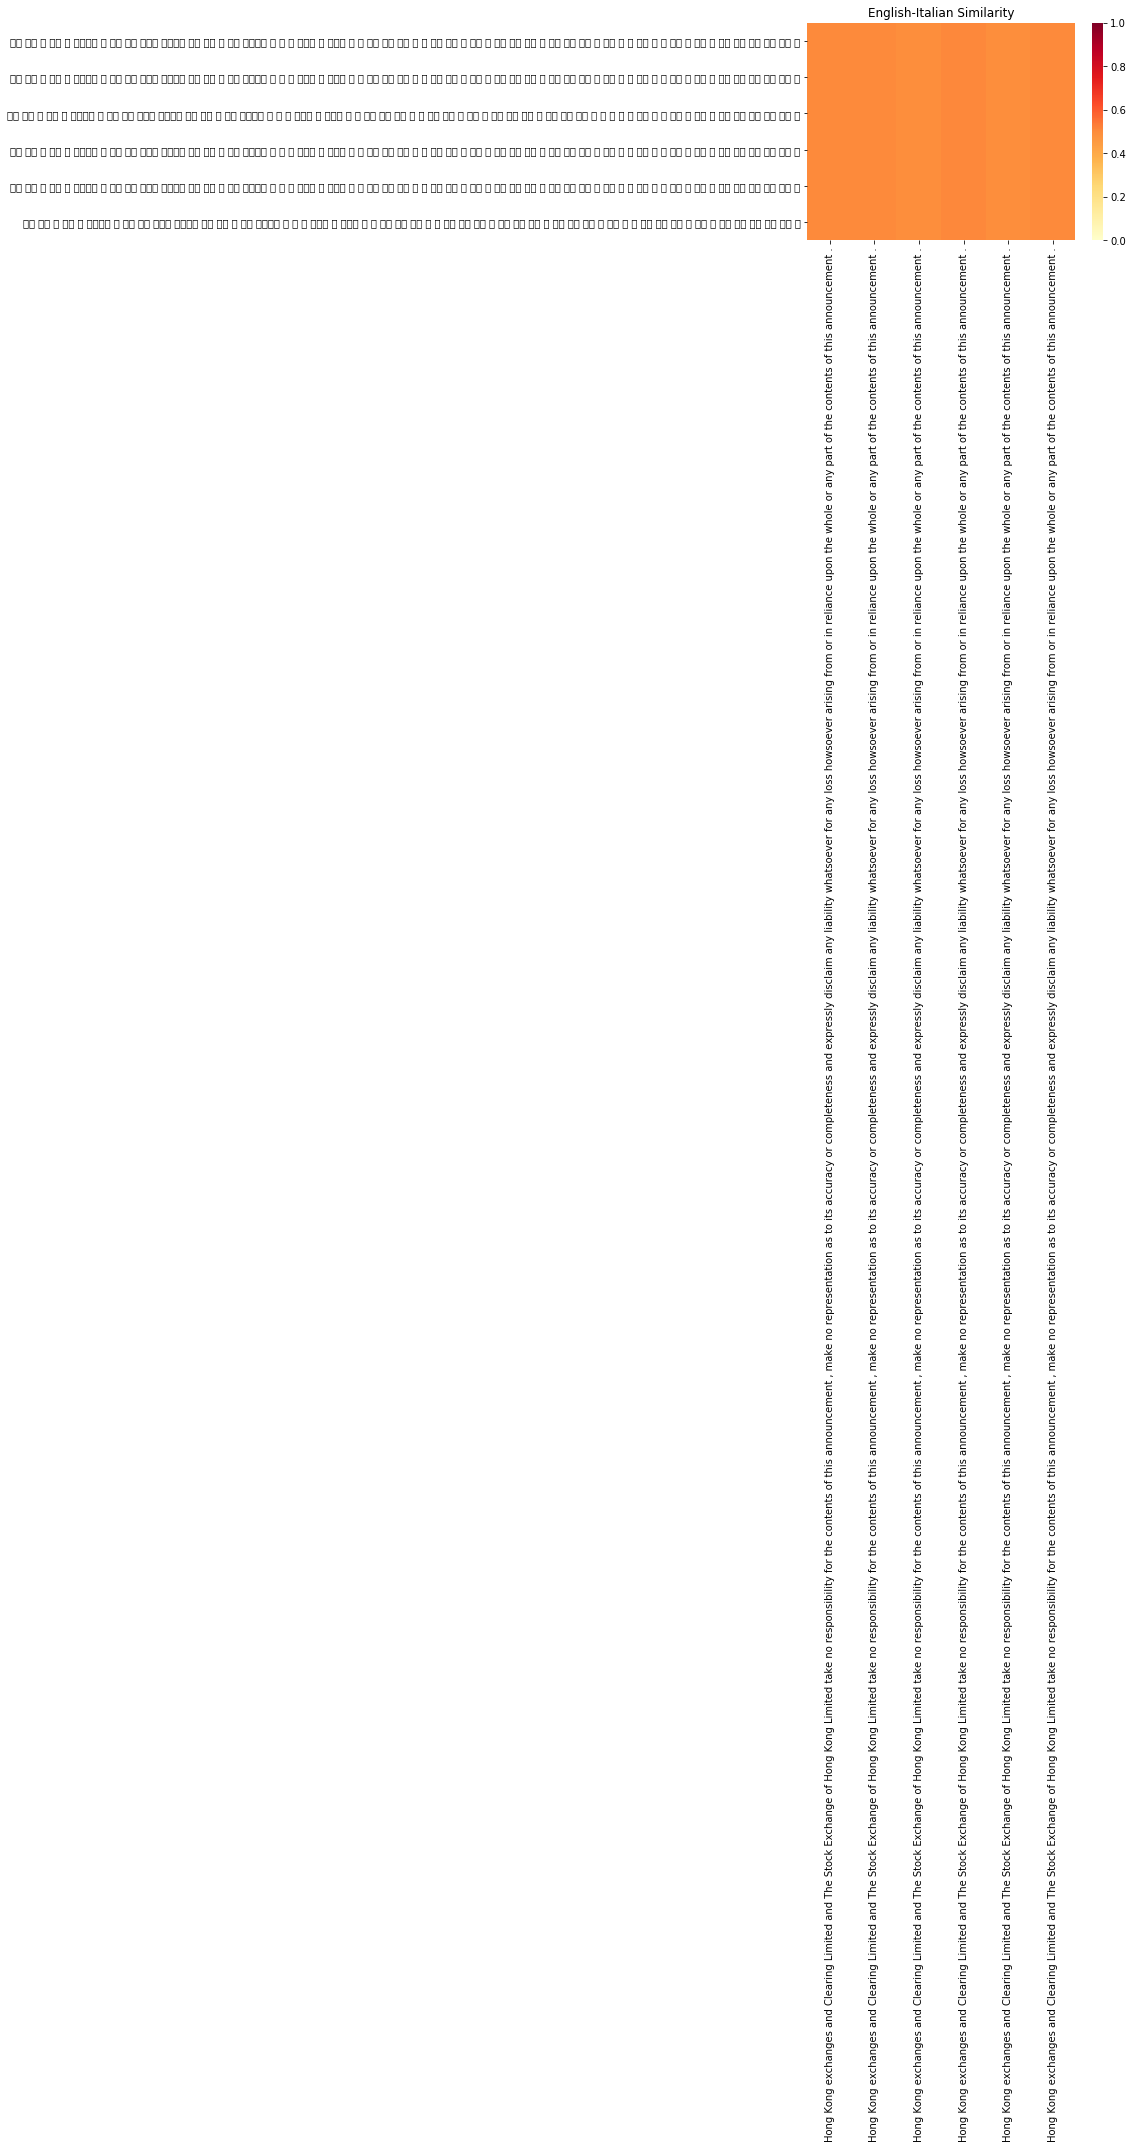

In [26]:
visualize_similarity(en_result, zh_result, english_sentences, chinese_sentences, "English-Italian Similarity")